In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd

import matplotlib.pyplot as plt

import json

In [2]:
chunksize = 10 ** 4
filepath = "data/2022_place_history_sorted.csv"

ddf = dd.read_csv(filepath)
ddf

,timestamp,user_id,pixel_color,coordinate
npartitions=54,,,,
,object,object,object,object
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


In [24]:
part = ddf.partitions[-7]
part["timestamp"] = dd.to_datetime(part["timestamp"])
# part.sort_values(by=["timestamp"], ascending=True)
part.compute().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2963517 entries, 0 to 2963516
Data columns (total 4 columns):
 #   Column       Dtype              
---  ------       -----              
 0   timestamp    datetime64[ns, UTC]
 1   user_id      object             
 2   pixel_color  object             
 3   coordinate   object             
dtypes: datetime64[ns, UTC](1), object(3)
memory usage: 90.4+ MB


In [4]:
timestamp_idx = 1
user_id_idx = 2

threshold = 0.2 # in seconds

count_dict = {}
variance_dict = {}
time_since_dict = {}
last_pixel_time_dict = {}

for row in part.itertuples():
    user_id = row[user_id_idx]
    if user_id in last_pixel_time_dict.keys():
        if user_id in time_since_dict.keys():
            time_since_last_pixel = row[timestamp_idx] - last_pixel_time_dict[row[user_id_idx]]
            variance = abs((time_since_dict[user_id] - time_since_last_pixel).total_seconds())
            if variance < threshold:
                if user_id not in count_dict.keys():
                    count_dict[user_id] = 0
                count_dict[user_id] += 1
            else:
                time_since_dict[user_id] = time_since_last_pixel
        else:
            time_since_dict[user_id] = row[timestamp_idx] - last_pixel_time_dict[user_id]
    last_pixel_time_dict[user_id] = row[timestamp_idx]


In [5]:
timestamp_idx = 1
user_id_idx = 2

threshold = 0.5 # in seconds

count_dict = {}
variance_dict = {}
time_since_dict = {}
last_pixel_time_dict = {}

for partit in ddf.partitions:
    partit["timestamp"] = dd.to_datetime(partit["timestamp"])
    for row in partit.itertuples():
        user_id = row[user_id_idx]
        if user_id in last_pixel_time_dict.keys():
            if user_id in time_since_dict.keys():
                time_since_last_pixel = row[timestamp_idx] - last_pixel_time_dict[row[user_id_idx]]
                variance = abs((time_since_dict[user_id] - time_since_last_pixel).total_seconds())
                if variance < threshold:
                    if user_id not in count_dict.keys():
                        count_dict[user_id] = 0
                    count_dict[user_id] += 1
                else:
                    time_since_dict[user_id] = time_since_last_pixel
            else:
                time_since_dict[user_id] = row[timestamp_idx] - last_pixel_time_dict[user_id]
        last_pixel_time_dict[user_id] = row[timestamp_idx]


In [6]:
with open('counts.txt', 'w') as convert_file:
    convert_file.write(json.dumps(count_dict))

In [7]:
count_series = pd.Series(count_dict)
count_series.sort_values(ascending=False)

fKNBueWS8c3w3vtqClU1+1QRi4qjHXOmX5aWta7QvKQj5aB6evQwiq2s8Lg6GV9rZcKjENT7+mNQE5AJXJGSBQ==    289
RAoIasI1HzzXLmG1c1izIOtKL9tjdd6oaGlS1tWID8EuRpKolxKzLzIgSGRpzl37FucfTCEKh2FlablcA7stAA==    287
TwvGv5iDGt6GKM94Y4L49H1G01PxJsJaOMdXxxAnL8vMP+5aB5pUNkN8GQ2wJ6xOJDep5PVC4rAzYN/b++GuOQ==    280
qqjD4zYwKS6FrxRkJfHKmxDEtFMEJ3ETGYYyMyNEE+2i9ul3WiqZ2glOks749PNfRdIeMbjz08yVEGEiVGs7gw==    276
/yEGU9BC+pEA3+t1oK4yy3wyQ7N/HN5/NwlLcyjuPa3Wrfp144xDKwreATH2SIMcGeiRrFWlYDS1H6qIziVuTQ==    276
                                                                                           ... 
Fp7EFy5mIzwUfkVGEXj5/cP00D+2NnvLM9xzx6jXeDmPtJXB3FgZ5rkjd3JkEFzZHhD7rkZHa4duA2vW+vPVYg==      1
dxnxmMxDGnXogWdbY1PJCPCFAqO2yTVn9HxZL9teeVzYQThdP6vr8xruaoSoqNSPAyRmD+Rlo2RaSNnH8lbNFQ==      1
boQmT3+/Z7B6vMsXy/+5D0MQDFMCQ6++mjZ1OGjZfMTcSVnvvbXYzeHAbKYA6RWiKnuYCwWr+FCeQQbT5EyzBg==      1
GL1m/kwvAuu6ya0qkvdo69GBmgufxTe6T+D8EhOeJo6BK3IPrLCzV9uHvqkQd+3myYOTQ9Wnds6LY+6z2HItlQ==      1
aqNS84ZAT6qEHewuAE9NOI1GxuuL3b6S2kI7dHmb

In [10]:
with open('user_ids.txt', 'w') as outfile:
    json.dump(list(count_dict.keys()), outfile)

(array([4.08451e+05, 2.95600e+03, 6.13000e+02, 2.00000e+02, 7.50000e+01,
        3.50000e+01, 2.70000e+01, 1.30000e+01, 3.00000e+00, 5.00000e+00]),
 array([  1. ,  29.8,  58.6,  87.4, 116.2, 145. , 173.8, 202.6, 231.4,
        260.2, 289. ]),
 <BarContainer object of 10 artists>)

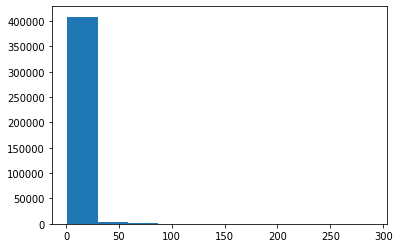

In [ ]:
plt.hist(count_series)

(array([1.0745e+04, 1.7550e+03, 4.4200e+02, 1.4800e+02, 6.3000e+01,
        3.0000e+01, 2.5000e+01, 1.2000e+01, 3.0000e+00, 5.0000e+00]),
 array([ 11. ,  38.8,  66.6,  94.4, 122.2, 150. , 177.8, 205.6, 233.4,
        261.2, 289. ]),
 <BarContainer object of 10 artists>)

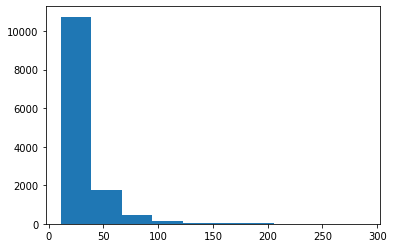

In [13]:
plt.hist(count_series.where(count_series > 10))

In [19]:
count_series[count_series > 2]

u7azOzo3yfh2Ij/tMO/as2zahtkxiMZYiueyI3J8+KzIVhDtDAlrahJh8XWY9emmKovUAvu+9+rJ0VLAKMJx6A==    16
UggFgLe2miQxn3F5NkPUr4kwLYzM3HuFCjqEWiWDvp3md0esfmLdVQ1dI6GoGXrltihBTCu7NRBEAcYrF4NClQ==    21
+Be2vrj9mt/552O7uM87yBzivHrAl3lOH94+MfGxbpZLgqOxNKjy+CGWlrvKT+gdJMAgR3fcqZcnFNLV29Qhrg==     9
yGauWjSJ+9wlzzDAdP8mCo7Xl1yd8YJw7Ndamqs03uOImG0rKdFzskE2wMiVUIdyrzxT3x1Bi6PKUmQlcxZTYw==     3
c+MqGVbTiVu98+Btv207lk4S9d21OKmcnb1YfBfWUKzGMewASGdUaSZcOe53vvHWHtXXlrmfTypll/K2PkV4+g==    50
                                                                                            ..
D94oF8CMRYKCIAqd9IHTVMV1S1UzJeLas0OuH2BScJ3VqP47jaG63pV6GBlD8GusC62L2z3wkg1Oi2wgN0SZfA==     3
/76Bx8XstJom5EurmZliFWLQ/V2FdRXiFQn1XxBhJ+rRIKl4r4xZocT6/kfljmI3XNHYPPAnp7xgd6qthca4LA==     3
YpH9dWFKjeGRWY8vd0iMdp88MYVE/wGZmY9a/H0USAsmNqxQjC7SVf1URqipRb3m3BXaYg2sOYKlfDpIKnThGA==     3
mj69r6as/b2uTriE4sUuumRLq+adU8ovpP2oPOOOeMJ+yTzxDaLkBCzXya6dJFMIcjN8AUN2v3DM++Z3KTfP5A==     3
gCaHNEomtV3JVNB5aUorDxN1yCIFBHd5/Gf/6tGY32y16n/3LH

In [21]:
with open('counts_greater_than_2.txt', 'w') as convert_file:
    convert_file.write(json.dumps(count_series[count_series > 2].to_dict()))

In [22]:
with open('user_ids_greater_than_2.txt', 'w') as outfile:
    json.dump(list(count_series[count_series > 2].to_dict().keys()), outfile)